# Imports 

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.nn import functional as F
import scipy
import sklearn
from umap import UMAP

import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from netcal.metrics import ECE, MCE
from netcal.scaling import TemperatureScaling
from netcal.presentation import ReliabilityDiagram
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import OneHotEncoder

# Analysis Functions 

In [16]:
def test_report(l, confidence=0.95):
    for df in l:
        df.columns = list(df.columns[1:]) + ['model_name']
        df['accuracy'] = 100 * df['accuracy']
        a = df['accuracy'].to_numpy()
       
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        print(m, h)

In [3]:
def conf_int(data, confidence=0.95):
    a = data.to_numpy()
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [4]:
def prob_metrics(df):
    df.columns = ['task', '0', '1', '2', '3', '4', 'actual']
    df[['0', '1', '2', '3', '4']] = F.softmax(torch.tensor(
        df[['0', '1', '2', '3', '4']].to_numpy()), dim=1).numpy()
    
    # Calculate ECE, MCE
    n_bins = 10
    confidences = df[['0', '1', '2', '3', '4']].to_numpy()
    ground_truth = df['actual'].to_numpy()
    ece = ECE(n_bins)
    mce = MCE(n_bins)
    uncalibrated_score_ece = ece.measure(confidences, ground_truth)
    temperature = TemperatureScaling()
    temperature.fit(confidences, ground_truth)
    calibrated = temperature.transform(confidences)
    calibrated_score_ece = ece.measure(calibrated, ground_truth)
    
    uncalibrated_score_mce = mce.measure(confidences, ground_truth)
    calibrated_score_mce = mce.measure(calibrated, ground_truth)
    # Reliability diagram
    diagram = ReliabilityDiagram(n_bins)
    diagram.plot(calibrated, ground_truth)
    sfig = a.get_figure()
    sfig.savefig('label_latents.svg', dpi=600,format='svg')
    
    return calibrated_score_ece, calibrated_score_mce

In [5]:
def report(df, tasks, confidence=0.95):
    df.columns = list(df.columns[1:]) + ['model_name']
    df['accuracy'] = 100 * df['accuracy']
    a = df['accuracy'].to_numpy()
    a = np.split(a, len(a)/tasks, axis=0)
    for accs in a:
        n = len(accs)
        m, se = np.mean(accs), scipy.stats.sem(accs)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        print(m, h)

# Analysing runs from CSV's

In [25]:
def plot_summarize(dfs, columns, meta_batch_size, batch_size):
    dfs[0] = dfs[0].groupby(np.arange(len(dfs[0])) // (meta_batch_size*batch_size)).mean()

    dfs[1].columns = ['model_name']+list(dfs[1].columns[1:])  
    dfs[1]['model_name']=df_valid['model_name'].apply(lambda x: 'model_'+str((x//batch_size)*batch_size)+'.pt')
    
    valid = dfs[1].groupby('model_name', as_index=False)[dfs[1].columns].mean()
    
    valid['iter'] = valid['model_name'].apply(
        lambda x: int(x[x.index('_') + 1:-3]))
    valid.sort_values(by=['iter'], inplace=True)
    valid.drop(columns=['model_name'], inplace=True)
    valid['accuracy'] = 100 * valid['accuracy'] 
    # Summarizing best valid scores
    ind = valid[valid['accuracy'] == valid['accuracy'].max()]['iter'].values[0]
    t = dfs[1][dfs[1]['model_name'] == 'model_' + str(ind) + '.pt']
    t['accuracy'] = 100 * t['accuracy']
    print('Validation Metrics Stats of Best Model at {}-th Iteration'.format(ind))
    display(t.describe())

    dfs[0].drop(columns=['task'], inplace=True)
    dfs[0].reset_index(drop=True, inplace=True)
    valid.reset_index(drop=True, inplace=True)

    dfs[0].columns = [str(c)+'_train' for c in columns]
    dfs[0]['accuracy_train'] = 100 * dfs[0]['accuracy_train']
    dfs[0]['iter'] = dfs[0].index
    
     

   # Create a chart with two vertical axes
    fig = make_subplots(specs=[[{"secondary_y": True}]])
 
    fig.update_layout(
        shapes=[
            dict(
                type="line",
                x0=0,  # Starting point x-coordinate, according to the spindle range
                x1=200,  # End point x-coordinate, according to the spindle range
                y0=100,    # y-coordinate of the horizontal line
                y1=100,    # y-coordinate of the horizontal line, same as the starting point
                line=dict(
                    color="black",  # Line color
                    width=1,         # Width of the line
                    dash="dash"      # Set the line as a dotted line
                )
            )
        ]
    )

    exclude_columns=['Reconst_Loss','accuracy']
    columns = [c for c in columns if c not in exclude_columns]

    # Plotting loss data
        
    for c in columns:
        fig.add_trace(go.Line(x=dfs[0].index, y=dfs[0][c + '_train'], name=c + '_train'), secondary_y=True)
    
    fig.add_trace(go.Line(x=dfs[0].index, y=dfs[0]['accuracy_train'], name='accuracy_train'), secondary_y=False)
    fig.add_trace(go.Line(x=valid['iter']//batch_size,y=valid['accuracy'],name='accuracy_valid'), secondary_y=False)
    
    # Update layout settings
    fig.update_layout(
        width=600,
        height=500,
        margin=dict(l=0, r=0, t=60, b=40),
        legend=dict(x=0, y=1, font=dict(size=12), bgcolor='rgba(255, 255, 255, 0.6)'), 
        xaxis=dict(title='Epochs (per 500)',  title_font=dict(size=17),tickfont=dict(size=14)),
        yaxis=dict(title='Accuracy (%)', title_font=dict(size=17), tickfont=dict(size=14),side='right'),
        yaxis2=dict(title='Loss', title_font=dict(size=17), tickfont=dict(size=14),side='left',overlaying='y'),
    )
 
 

    # Show tables
    fig.show()
    
#   # save
#     pio.write_image(fig, 'loss_Miniimagenet_5_1.svg', format='svg')
    
    #return df, test

In [67]:
df_train = pd.read_csv(f'logs/TRIDENT_miniimagenet_5-way_1-shot_10-queries/TSDVI_Zl/train.csv')
df_valid = pd.read_csv(f'logs/TRIDENT_miniimagenet_5-way_1-shot_10-queries/TSDVI_Zl/valid.csv')

In [68]:
plot_summarize([df_train, df_valid], ['accuracy', 'ELBO', 'Label_KL', 'Agnostic_KL', 'Reconst_Loss', 'CE_Loss'], 5,500)

Validation Metrics Stats of Best Model at 99500-th Iteration


/tmp/ipykernel_328/128939614.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,accuracy,ELBO,Label_KL,Style_KL,Reconst_Loss,CE_Loss
count,500.000000,500.000000,500.000000,500.000000,500.000000,0.0
mean,80.567998,61.211630,9.037307,0.000229,0.521741,NaN
std,9.856555,22.585513,1.693064,0.000893,0.225432,NaN
min,38.000000,22.205839,6.699264,0.000001,0.119621,NaN
25%,74.000001,44.586521,8.104095,0.000005,0.355527,NaN
50%,81.999999,57.616491,8.640376,0.000010,0.491035,NaN
75%,88.000000,74.387102,9.402918,0.000099,0.653594,NaN
max,97.999996,162.307739,20.119770,0.013539,1.442121,NaN


/home/zjh/miniconda3/envs/t/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [79]:

df_test = pd.read_csv(f'logs/TRIDENT_test_miniimagenet_5-way_5-shot_10-queries/tsdvi_zl/test.csv')
test_report([df_test]) # Can also run test.py multiple times for multiple test.csv's and add in the argument list  


82.67999767760436 0.6391595268990613


In [78]:

df_test = pd.read_csv(f'logs/TRIDENT_test_miniimagenet_5-way_1-shot_10-queries/inductive2/test.csv')
test_report([df_test])


98.42999856670697 0.17717605989782792


# Prob Metrics 

0.000395672980624264 0.02327230214574627


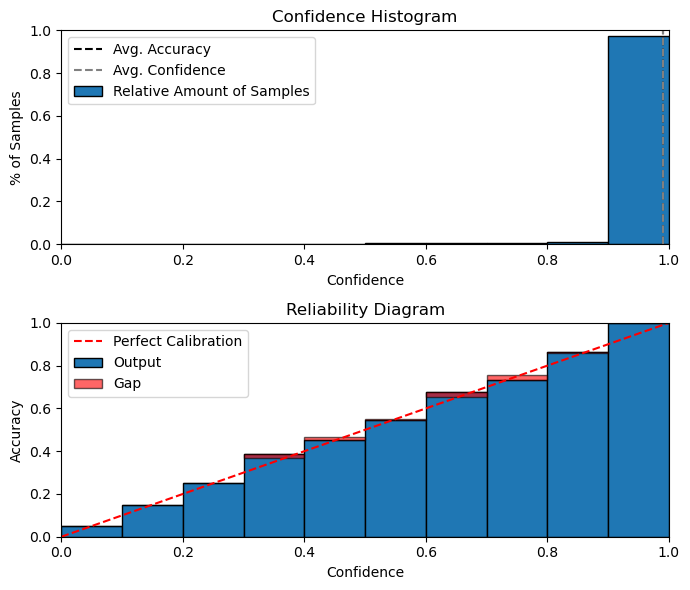

In [284]:
df_preds = pd.read_csv('logs/TRIDENT_test_cifarfs_5-way_1-shot_10-queries/inductive1/preds.csv')
ece, mce = prob_metrics(df_preds)
print(ece,mce)


In [263]:
def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))
encoder = OneHotEncoder(sparse=False)
onehot = encoder.fit_transform(np.array(df_preds['actual']).reshape(-1, 1))
brier_multi(onehot, df_preds[['0','1','2','3','4']])

0.01521647795453802

# Visualizing the Latents 

In [76]:
latents0 = torch.load(f'logs/TRIDENT_test_miniimagenet_5-way_1-shot_10-queries/inductive2/latents_0_epoch-204_test.pt')
latents = torch.load(f'logs/TRIDENT_test_miniimagenet_5-way_1-shot_10-queries/inductive2/latents_epoch-204_test.pt')

In [80]:
# Making Before and After latent-datasets 
df0 = pd.DataFrame(np.array(latents0['label_latents'][0]))
df0['class'] = pd.Series(list(np.full((10,), 0)) + list(np.full((10,), 1)) + list(
    np.full((10,), 2)) + list(np.full((10,), 3)) + list(np.full((10,), 4)))
features0 = df0.iloc[:, :-1]
df = pd.DataFrame(np.array(latents['label_latents'][0]))
df['class'] = pd.Series(list(np.full((10,), 0)) + list(np.full((10,), 1)) + list(
    np.full((10,), 2)) + list(np.full((10,), 3)) + list(np.full((10,), 4)))
features = df.iloc[:, :-1]

# UMAP projection to 2D space 
umap = UMAP(n_components=2, init='random', random_state=0)
proj_2d0 = umap.fit_transform(features0)
umap = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap.fit_transform(features)

In [81]:
sklearn.metrics.davies_bouldin_score(proj_2d0, df['class'])

6.299372913816166

In [82]:
sklearn.metrics.davies_bouldin_score(proj_2d, df['class'])

0.3090310584345325

<Figure size 2500x1200 with 0 Axes>

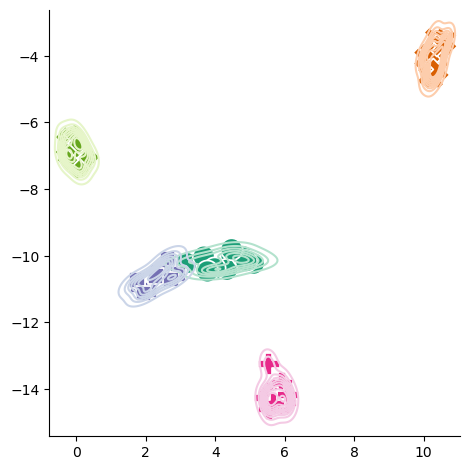

In [83]:
plt.figure(figsize=(25, 12))
sns.relplot(x=proj_2d[:, 0], y=proj_2d[:, 1], hue=df['class'].astype(
    int), palette="Dark2", style=df['class'].astype(int), s=250, legend=False)
a=sns.kdeplot(x=proj_2d[:, 0], y=proj_2d[:, 1],
            hue=df['class'].astype(int), palette="Pastel2", legend=False)
sns.despine(right=True)

In [84]:
sfig = a.get_figure()
sfig.savefig('label_latents_5_1.svg', dpi=600,format='svg')

<Figure size 1000x600 with 0 Axes>

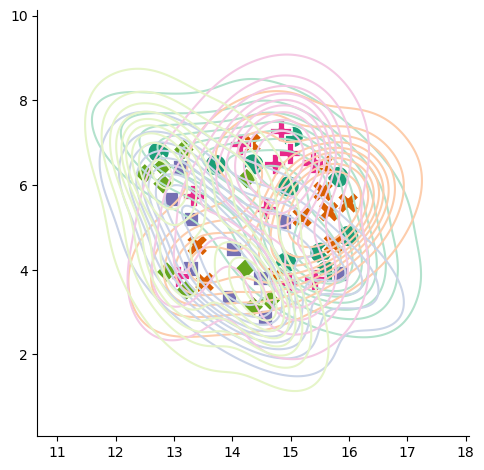

In [85]:
plt.figure(figsize=(10, 6))
sns.relplot(x=proj_2d0[:, 0], y=proj_2d0[:, 1], hue=df['class'].astype(
    int), palette="Dark2", style=df['class'].astype(int), s=250, legend=False)
a=sns.kdeplot(x=proj_2d0[:, 0], y=proj_2d0[:, 1],
            hue=df['class'].astype(int), palette="Pastel2", legend=False)
sns.despine(right=True)

In [86]:
sfig = a.get_figure()
sfig.savefig('label_latents0_5_1.svg', dpi=600,format='svg')

In [87]:
# Making Before and After latent-datasets 
df0 = pd.DataFrame(np.array(latents0['style_latents'][0]))
df0['class'] = pd.Series(list(np.full((10,), 0)) + list(np.full((10,), 1)) + list(
    np.full((10,), 2)) + list(np.full((10,), 3)) + list(np.full((10,), 4)))
features0 = df0.iloc[:, :-1]
df = pd.DataFrame(np.array(latents['style_latents'][0]))
df['class'] = pd.Series(list(np.full((10,), 0)) + list(np.full((10,), 1)) + list(
    np.full((10,), 2)) + list(np.full((10,), 3)) + list(np.full((10,), 4)))
features = df.iloc[:, :-1]

# UMAP projection to 2D space
umap = UMAP(n_components=2, init='random', random_state=0)
proj_2d0 = umap.fit_transform(features0)
umap = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap.fit_transform(features)

In [88]:
sklearn.metrics.davies_bouldin_score(proj_2d0, df['class'])

5.227345233871027

In [89]:
sklearn.metrics.davies_bouldin_score(proj_2d, df['class'])

4.793323366266446

<Figure size 1000x600 with 0 Axes>

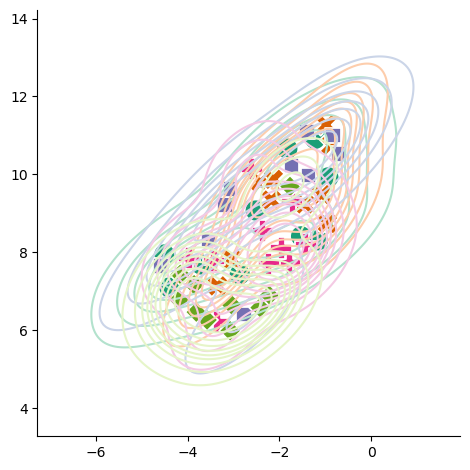

In [90]:
plt.figure(figsize=(10, 6))
sns.relplot(x=proj_2d[:, 0], y=proj_2d[:, 1], hue=df['class'].astype(
    int), palette="Dark2", style=df['class'].astype(int), s=250, legend=False)
a=sns.kdeplot(x=proj_2d[:, 0], y=proj_2d[:, 1],
            hue=df['class'].astype(int), palette="Pastel2", legend=False)
sns.despine(right=True)





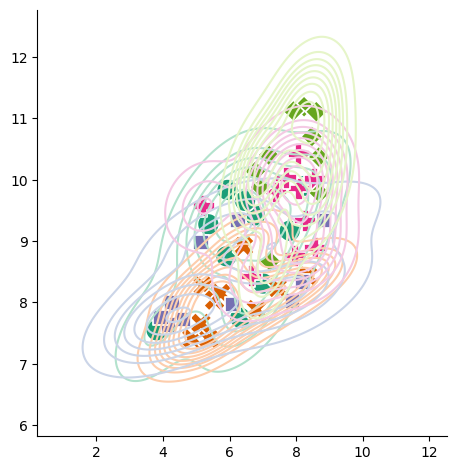

In [92]:
#plt.figure(figsize=(10, 6))
sns.relplot(x=proj_2d0[:, 0], y=proj_2d0[:, 1], hue=df['class'].astype(
    int), palette="Dark2", style=df['class'].astype(int), s=250, legend=False)
a= sns.kdeplot(x=proj_2d0[:, 0], y=proj_2d0[:, 1],
            hue=df['class'].astype(int), palette="Pastel2", legend=False)
sns.despine(right=True)



